# Housing Projesi <a name="baslik"></a>

1. [Gerekli Kütüphaneler](#gerekli-kutuphaneler)
2. [Gerekli Ayarlar](#gerekli-ayarlar)
    1. [Uyarıların Görmezden Gelinmesi](#uyarilarin-gormezden-gelinmesi)
    2. [İşletim Sistemi](#isletim-sistemi)
    3. [Pandas](#pandas)
3. [S3 Erişimi](#s3-erisimi)
4. [Oluşturulan Fonksiyonlar](#olusturulan-fonksiyonlar)
5. [Veri Setinin Yüklenmesi](#veri-setinin-yuklenmesi)
6. [Keşfedici Veri Analizi](#kva)
    1. [Analiz Değişkenlerinin Belirlenmesi](#degsikenler)
        1. [Kategorik Değişkenler](#kategorik-degiskenler)
        2. [Sayisal Degiskenler](#sayisal-degiskenler)
        3. [Değişken Sayıları](#degsiken-sayilari)
    2. [Sayısal Değişken Analizi](#sda)
        1. [Betimleyici İstatistik](#betimleyici-istatistik)
        2. [Histogram ve Kutu Grafiği](#sayisal-grafikler)
        3. [Kırılımlı Histogram](#kirilimli-histogram)
        4. [Kırılımlı Kutu Grafiği](#kirilimli-boxplot)
        5. [Tek Kategorili Çapraz Tablo](#capraz-tablo)
    3. [Kategorik Değişken Analizi](#kda)
    4. [Korelasyon Analizi](#korelasyon)
        1. [Normallik Testi](#kstest)
        2. [Korelasyon Tablosu](#korelasyon-tablosu)
    5. [Eksik Değer Analizi](#eda)
        1. [Eksik Değer Tablosu](#edt)
        2. [Eksik Değerin Görselleştirilmesi](#edg)
        3. [Eksikliğin Hedef Değişken ile İlişkisi](#ehdi)
7. [Modele Hazırlık](#model-giris)
    1. [Tüm Değişkenlerin Sayısallaştırılması](#sayisallastirma)
    2. [Eksik Değerlerin Silinmesi](#eksik-deger-silme)
    3. [Bağımlı Değişkenin ve Bağımsız Değişkenlerin Belirlenmesi](#degiskenleri-belirleme)
    4. [Eğitim ve Test Setinin Ayrılması](#egitim-test)
8. [MLflow ile Modelleme](#mlflow-giris)
    1. [Modellerin Tanımlanması](#model-secim)
    2. [Modellerin MLflow'a Gönderilmesi](#mlflow-logging)

## Gerekli Kütüphaneler <a name="gerekli-kutuphaneler"></a>

In [1]:
import io
import os
import boto3
import logging
import mlflow
import warnings
import mlflow.sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy.stats import kstest
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

[Yukarı Çık](#baslik)

## Gerekli Ayarlar <a name="gerekli-ayarlar"></a>

### Uyarıların Görmezden Gelinmesi <a name="uyarilarin-gormezden-gelinmesi"></a>

In [2]:
warnings.filterwarnings("ignore")

[Yukarı Çık](#baslik)

### İşletim Sistemi <a name="isletim-sistemi"></a>

In [3]:
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5000/'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9000/'

[Yukarı Çık](#baslik)

### Pandas <a name="pandas"></a>

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.expand_frame_repr', False)

[Yukarı Çık](#baslik)

## S3 Erişimi <a name="s3-erisimi"></a>

In [5]:
s3_res = boto3.resource('s3', 
                        aws_access_key_id="trainkey", 
                        aws_secret_access_key="trainsecret",
                       endpoint_url='http://localhost:9000')

client = boto3.client('s3', 
                        aws_access_key_id="trainkey", 
                        aws_secret_access_key="trainsecret",
                       endpoint_url='http://localhost:9000')

[Yukarı Çık](#baslik)

## Oluşturulan Fonksiyonlar <a name="olusturulan-fonksiyonlar"></a>

In [6]:
def load_df_from_s3(bucket, key, s3_client, *args, **kwargs):
    ''' Read a csv from a s3 bucket & load into pandas dataframe'''
    try:
        logging.info(f"Loading {bucket, key}")
        obj = s3_client.get_object(Bucket=bucket, Key=key)
        return pd.read_csv(obj['Body'], *args, **kwargs)
    except Exception as e:
        raise logging.exception(e)

In [7]:
def eval_metrics(actual, pred):
    """
    rmse, mae ve r^2 metriklerini oluşturan fonksiyon.
    """
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

[Yukarı Çık](#baslik)

## Veri Setinin Yüklenmesi <a name="veri-setinin-yuklenmesi"></a>

In [8]:
df = load_df_from_s3(bucket="vbo-mlflow-bucket",
                             key="housing.csv",
                             s3_client=client,
                             index_col=None,
                             usecols=None,
                             sep=",")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23000,37.88000,41.00000,880.00000,129.00000,322.00000,126.00000,8.32520,452600.00000,NEAR BAY
1,-122.22000,37.86000,21.00000,7099.00000,1106.00000,2401.00000,1138.00000,8.30140,358500.00000,NEAR BAY
2,-122.24000,37.85000,52.00000,1467.00000,190.00000,496.00000,177.00000,7.25740,352100.00000,NEAR BAY
3,-122.25000,37.85000,52.00000,1274.00000,235.00000,558.00000,219.00000,5.64310,341300.00000,NEAR BAY
4,-122.25000,37.85000,52.00000,1627.00000,280.00000,565.00000,259.00000,3.84620,342200.00000,NEAR BAY


[Yukarı Çık](#baslik)

## Keşifçi Veri Analizi <a name="kva"></a>

### Analiz Değişkenlerinin Belirlenmesi <a name="degsikenler"></a>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
hedef_degisken = 'median_house_value'

In [11]:
pd.concat([df.nunique(), df.dtypes], axis=1, keys=['nunique', 'dtpyes'])

,nunique,dtpyes
longitude,844,float64
latitude,862,float64
housing_median_age,52,float64
total_rooms,5926,float64
total_bedrooms,1923,float64
population,3888,float64
households,1815,float64
median_income,12928,float64
median_house_value,3842,float64
ocean_proximity,5,object


[Yukarı Çık](#baslik)

#### Kategorik Değişkenler <a name="kategorik-degiskenler"></a>

In [12]:
# Object veya Category tiplerini seçme
kategorik_tip = [col for col in df.select_dtypes(exclude=['number']) if col != hedef_degisken]
# Kategorik görünen sayısal sütunları seçme
sayisal_ama_kategorik = [col for col in df.select_dtypes(include=['number']) if df[col].nunique() <= 13]
# Sınıf sayısı yüksek olan sütunları seçme
kategorik_ama_kardinal = [col for col in kategorik_tip if df[col].nunique() > 20]
# Kategorik değişken listesini oluşturma
kategorik_degiskenler = list(set(kategorik_tip + sayisal_ama_kategorik) - set(kategorik_ama_kardinal))

[Yukarı Çık](#baslik)

#### Sayısal Değişkenler <a name="sayisal-degiskenler"></a>

In [13]:
# int veya float tiplerini seçme
sayisal_tip = [col for col in df.select_dtypes(include=['number']) if col != hedef_degisken]
# Sayısal değişken listesini oluşturma
sayisal_degiskenler = list(set(sayisal_tip) - set(sayisal_ama_kategorik))

[Yukarı Çık](#baslik)

#### Değişken Sayıları <a name="degsiken-sayilari"></a>

In [14]:
sayisal_degisken_sayisi = len(sayisal_degiskenler)
kategorik_degisken_sayisi = len(kategorik_degiskenler)

[Yukarı Çık](#baslik)

### Sayısal Değişken Analizi <a name="sda"></a>

#### Betimleyici İstatistik <a name="betimleyici-istatistik"></a>

In [15]:
df[sayisal_degiskenler].describe([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
latitude,20640.00000,35.63186,2.13595,32.54000,32.68000,32.82000,33.63000,33.93000,34.26000,37.71000,38.48000,38.96000,40.62610,41.95000
housing_median_age,20640.00000,28.63949,12.58556,1.00000,4.00000,8.00000,13.00000,18.00000,29.00000,37.00000,46.00000,52.00000,52.00000,52.00000
households,20640.00000,499.53968,382.32975,1.00000,31.00000,125.00000,184.00000,280.00000,409.00000,605.00000,890.00000,1162.00000,1982.66000,6082.00000
total_bedrooms,20433.00000,537.87055,421.38507,1.00000,36.00000,137.00000,198.00000,296.00000,435.00000,647.00000,965.00000,1275.40000,2221.36000,6445.00000
median_income,20640.00000,3.87067,1.89982,0.49990,1.06963,1.60057,1.90380,2.56340,3.53480,4.74325,6.15921,7.30030,10.59654,15.00010
population,20640.00000,1425.47674,1132.46212,3.00000,88.00000,348.00000,510.00000,787.00000,1166.00000,1725.00000,2566.00000,3288.00000,5805.83000,35682.00000
longitude,20640.00000,-119.56970,2.00353,-124.35000,-123.22000,-122.47000,-122.29000,-121.80000,-118.49000,-118.01000,-117.25000,-117.08000,-116.29000,-114.31000
total_rooms,20640.00000,2635.76308,2181.61525,2.00000,164.00000,620.95000,941.00000,1447.75000,2127.00000,3148.00000,4651.50000,6213.20000,11212.11000,39320.00000


[Yukarı Çık](#baslik)

#### Histogram ve Kutu Grafiği <a name="sayisal-grafikler"></a>

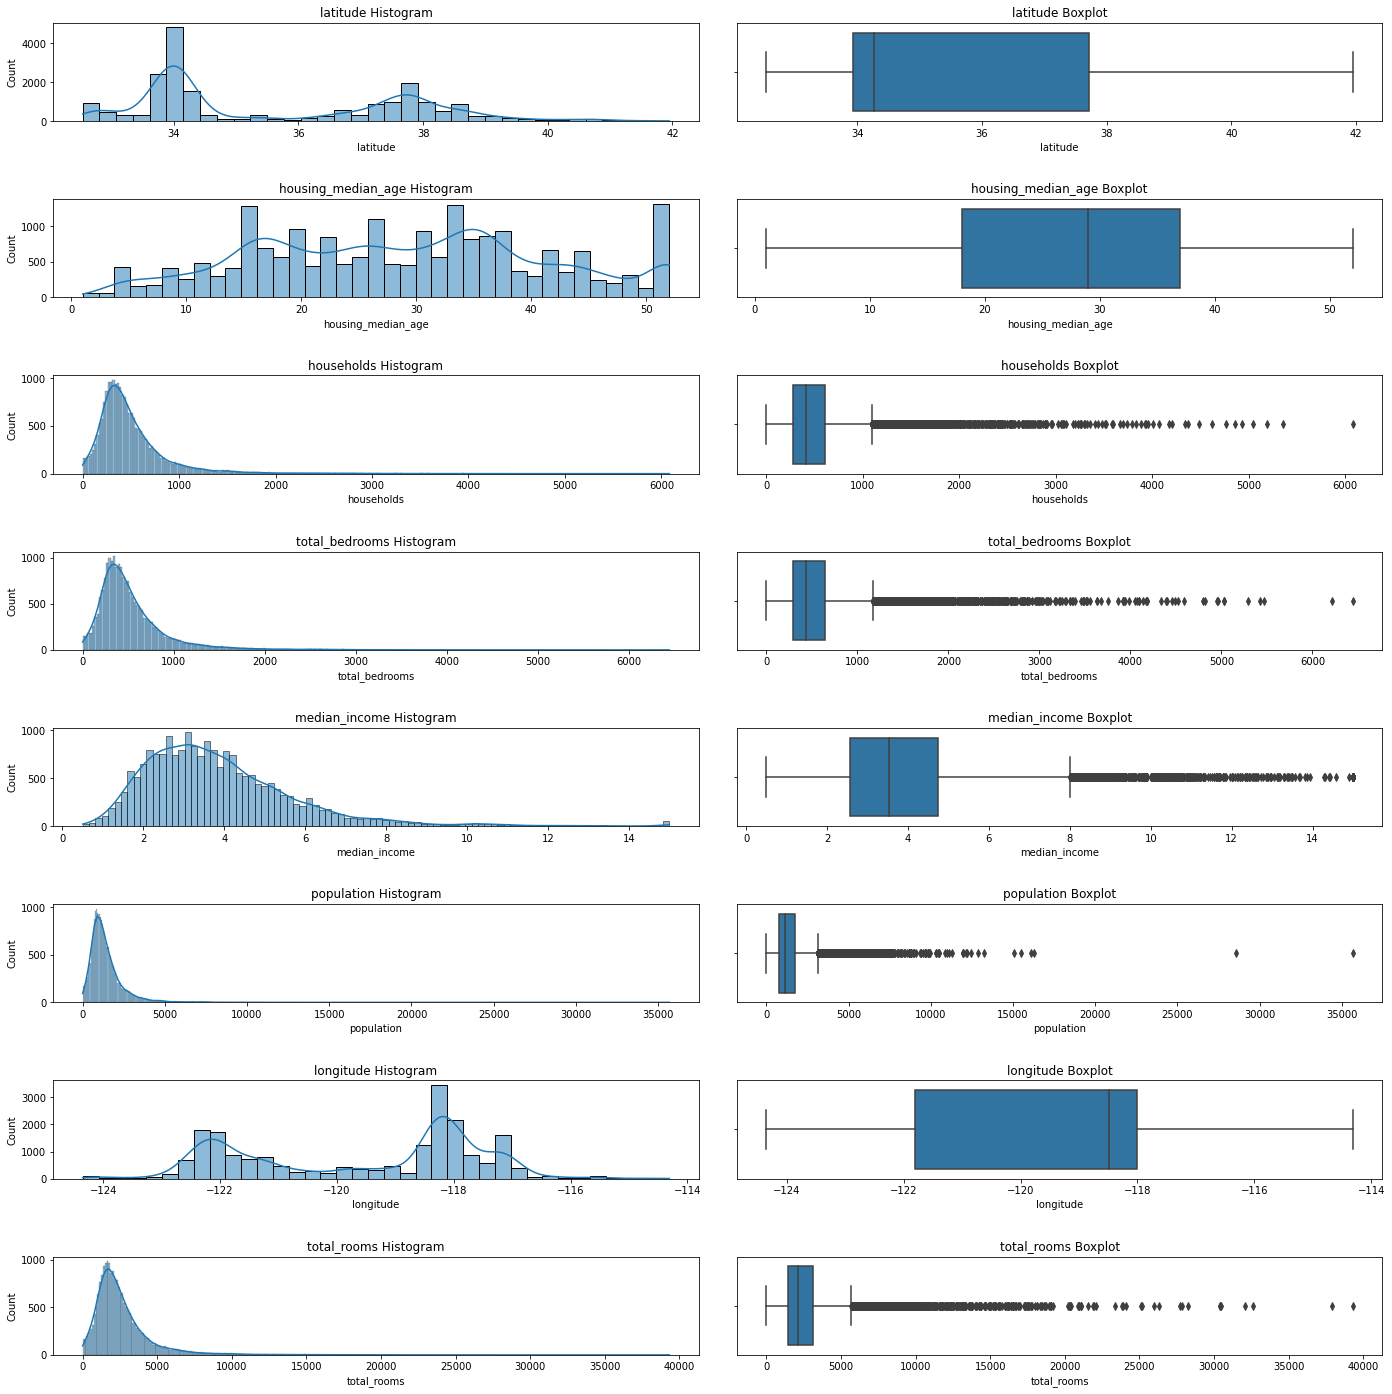

In [16]:
fig, axes = plt.subplots(sayisal_degisken_sayisi, 2, squeeze=False, figsize=(20, 20))
for i in range(sayisal_degisken_sayisi):
    axes[i, 0].set_title(f'{sayisal_degiskenler[i]} Histogram')
    sns.histplot(data=df, x=sayisal_degiskenler[i], kde=True, ax=axes[i, 0])
    axes[i, 1].set_title(f'{sayisal_degiskenler[i]} Boxplot')
    sns.boxplot(data=df, x=sayisal_degiskenler[i], ax=axes[i, 1])
fig.tight_layout(pad=3.0)
plt.show()

[Yukarı Çık](#baslik)

#### Kırılımlı Histogram <a name="kirilimli-histogram"></a>

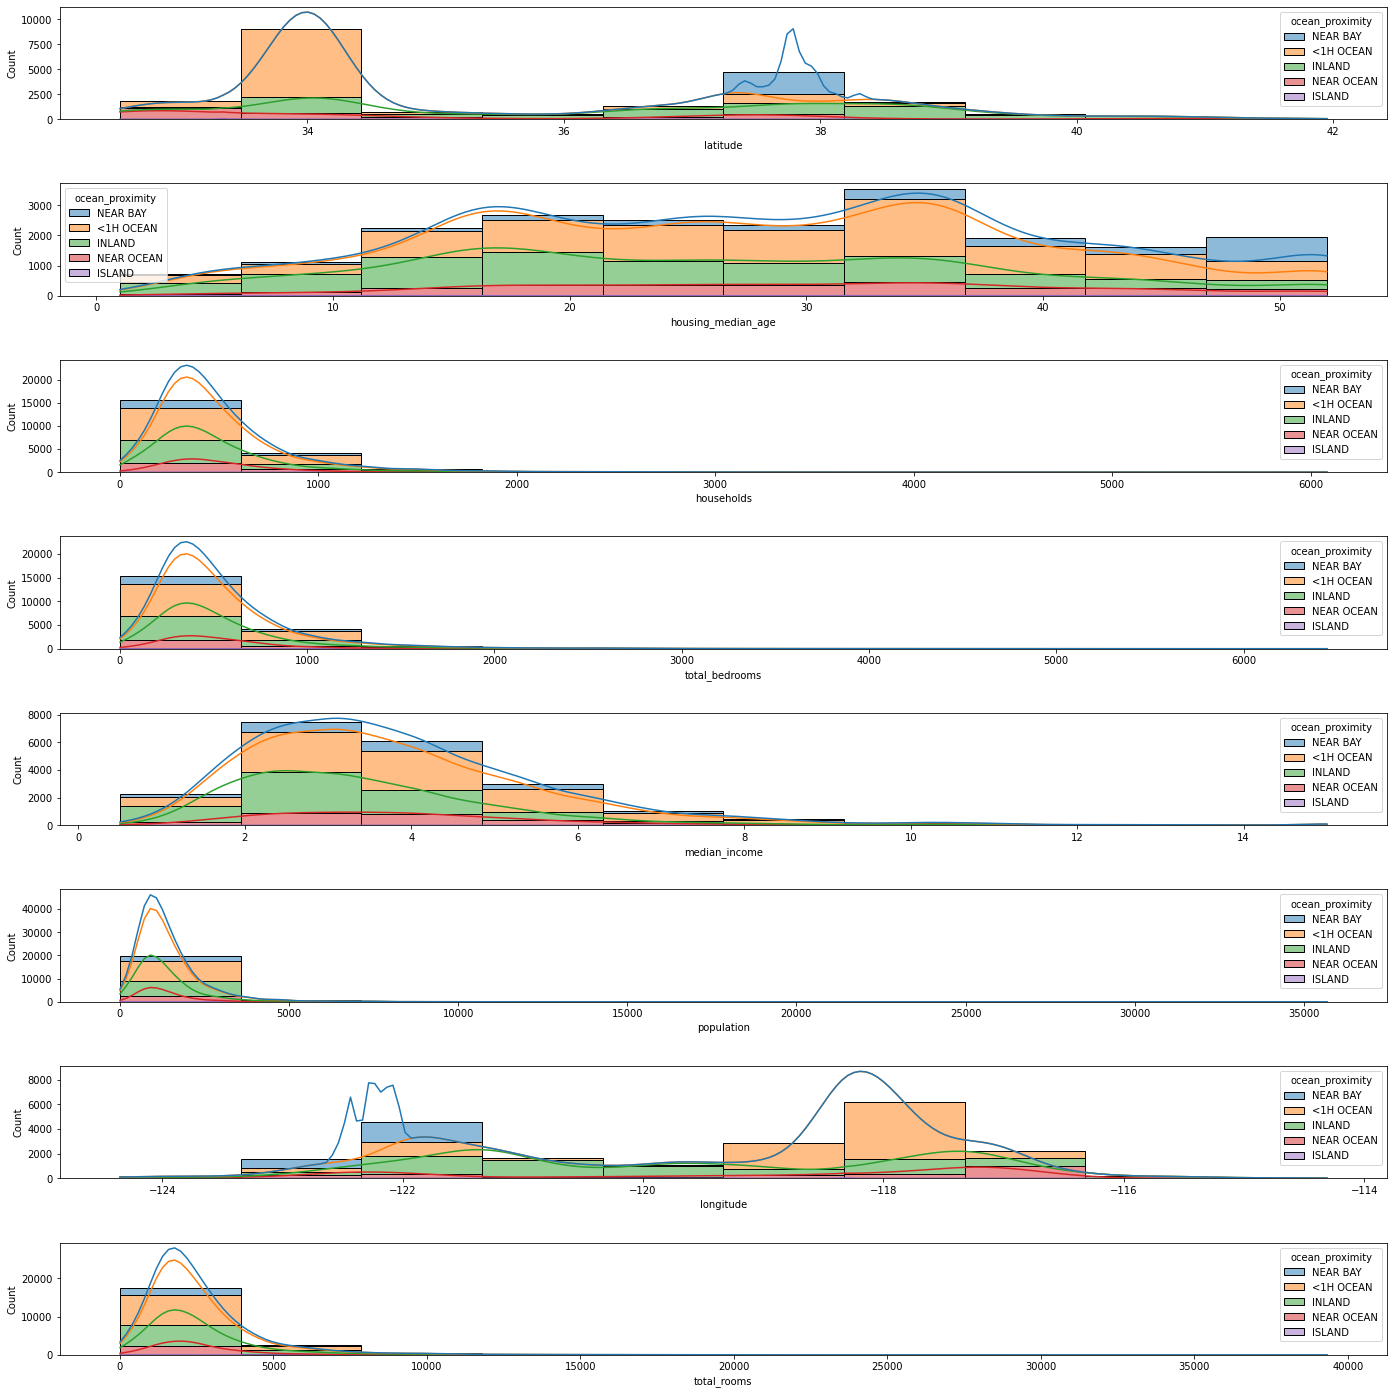

In [17]:
fig, axes = plt.subplots(sayisal_degisken_sayisi, kategorik_degisken_sayisi, squeeze=False, figsize=(20, 20))
for i in range(sayisal_degisken_sayisi):
    for j in range(kategorik_degisken_sayisi):
        sns.histplot(data=df, x=sayisal_degiskenler[i], hue=kategorik_degiskenler[j], multiple="stack", kde=True, bins=10, ax=axes[i,j])
fig.tight_layout(pad=3.0)
plt.show()

[Yukarı Çık](#baslik)

#### Kırılımlı Kutu Grafiği <a name="kirilimli-boxplot"></a>

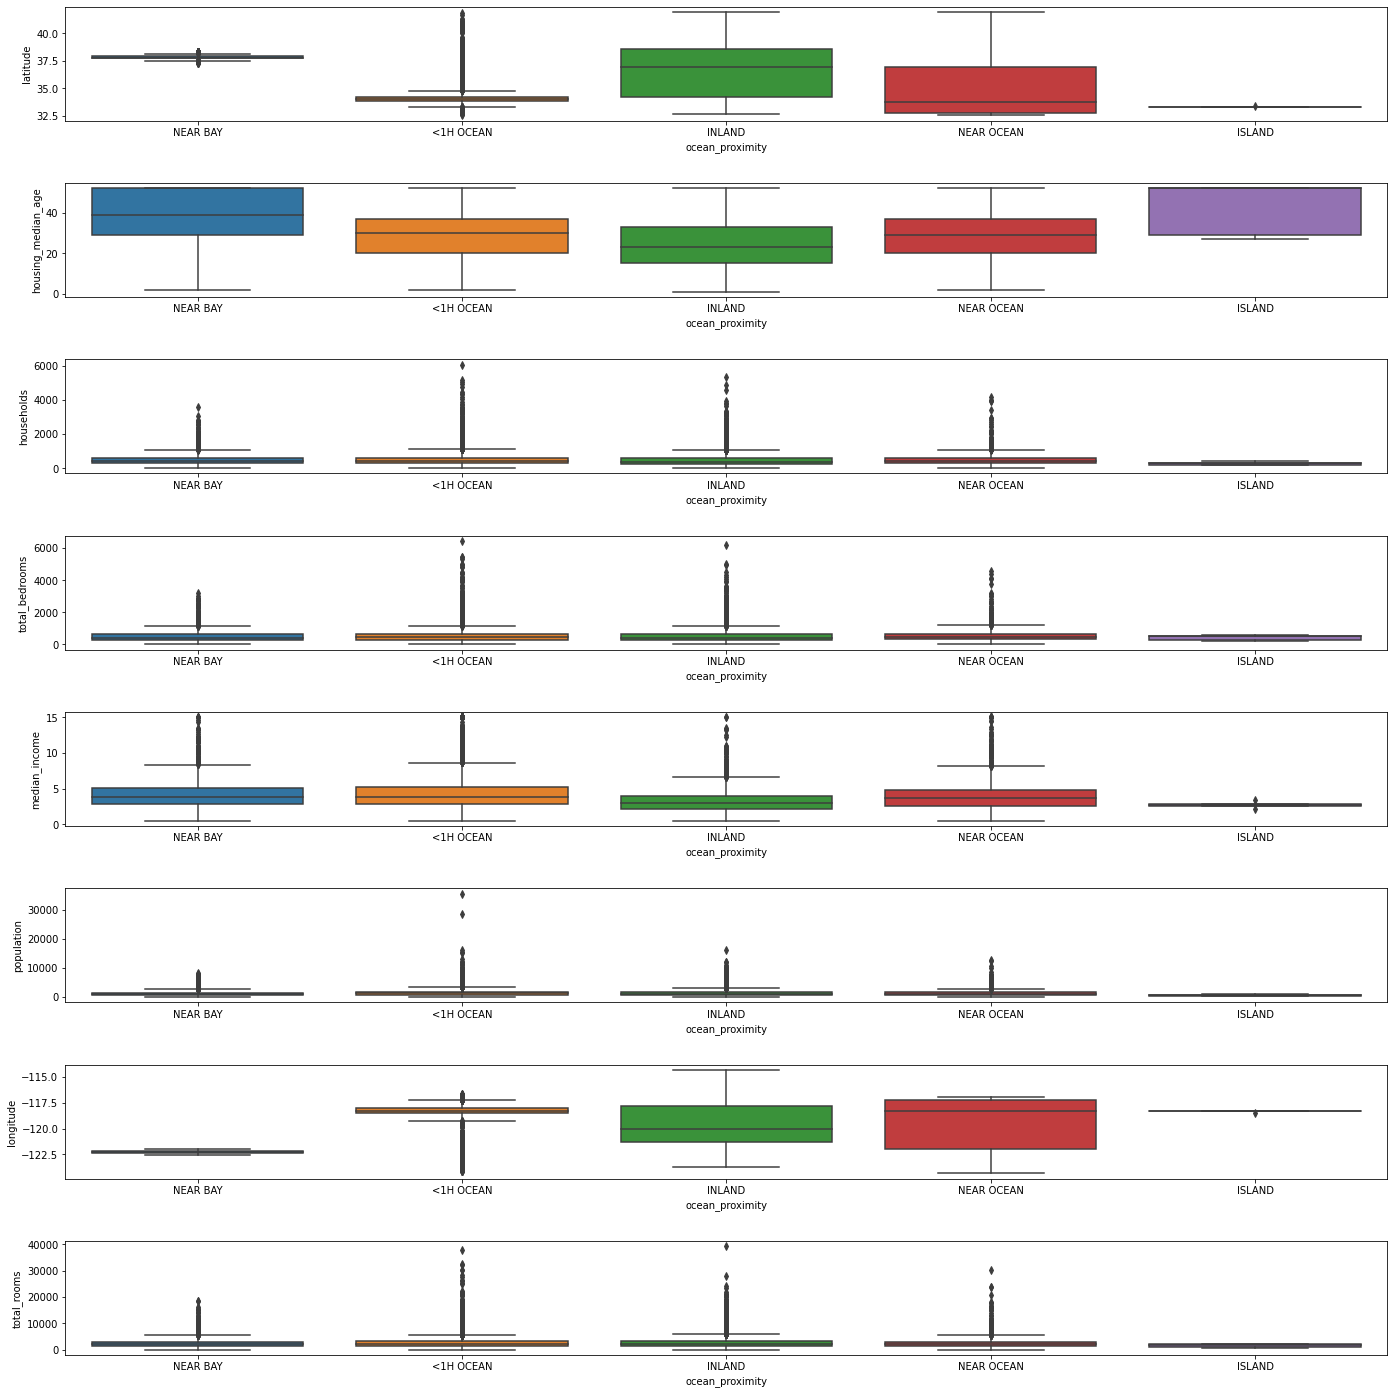

In [18]:
fig, axes = plt.subplots(sayisal_degisken_sayisi, kategorik_degisken_sayisi, squeeze=False, figsize=(20, 20))
for i in range(sayisal_degisken_sayisi):
    for j in range(kategorik_degisken_sayisi):
        sns.boxplot(data=df, x=kategorik_degiskenler[j], y=sayisal_degiskenler[i], ax=axes[i,j])
fig.tight_layout(pad=3.0)
plt.show()

[Yukarı Çık](#baslik)

#### Tek Kategorili Çapraz Tablo <a name="capraz-tablo"></a>

In [19]:
toplulastırma_fonksiyonlari = ['count', 'mean', 'median']

for sayisal in sayisal_degiskenler:
    for kategorik in kategorik_degiskenler:
        print(f'- {kategorik.upper()} KIRILIMINDA {sayisal.upper()} ISTATISTIKLERI -'.center(100, '#'), end='\n\n\n')
        grup_tablo = df.groupby(kategorik, as_index=False).agg({sayisal: toplulastırma_fonksiyonlari})
        grup_tablo.columns = [kategorik] + [f'{sayisal}_{fonksiyon}' for fonksiyon in toplulastırma_fonksiyonlari]
        grup_tablo.sort_values(f'{sayisal}_mean', ascending=False, ignore_index=True, inplace=True)
        print(grup_tablo, end='\n\n\n')

######################- OCEAN_PROXIMITY KIRILIMINDA LATITUDE ISTATISTIKLERI -#######################


  ocean_proximity  latitude_count  latitude_mean  latitude_median
0        NEAR BAY            2290       37.80106         37.79000
1          INLAND            6551       36.73183         36.97000
2      NEAR OCEAN            2658       34.73844         33.79000
3       <1H OCEAN            9136       34.56058         34.03000
4          ISLAND               5       33.35800         33.34000


#################- OCEAN_PROXIMITY KIRILIMINDA HOUSING_MEDIAN_AGE ISTATISTIKLERI -##################


  ocean_proximity  housing_median_age_count  housing_median_age_mean  housing_median_age_median
0          ISLAND                         5                 42.40000                   52.00000
1        NEAR BAY                      2290                 37.73013                   39.00000
2      NEAR OCEAN                      2658                 29.34725                   29.00000
3       <1H 

[Yukarı Çık](#baslik)

### Kategorik Değişken Analizi <a name="kda"></a>

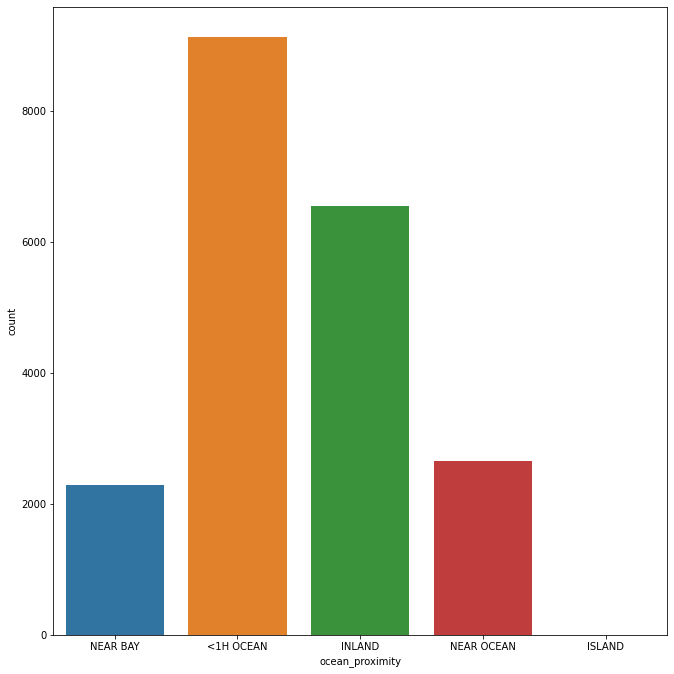

In [20]:
fig, axes = plt.subplots(kategorik_degisken_sayisi, figsize=(10,10))
for i in range(kategorik_degisken_sayisi):
    sns.countplot(x=kategorik_degiskenler[i], data=df, ax=axes)
fig.tight_layout(pad=3.0)
plt.show()

[Yukarı Çık](#baslik)

### Korelasyon Analizi <a name="korelasyon"></a>

#### Normallik Testi <a name="kstest"></a>

In [21]:
hepsi_normal_dagiliyor_mu = True

for sayisal in sayisal_degiskenler:
    pvalue = kstest(df[sayisal], 'norm')[1]
    if pvalue < 0.05:
        hepsi_normal_dagiliyor_mu = False
        break

if hepsi_normal_dagiliyor_mu:
    korelasyon_tablosu = df[sayisal_degiskenler].corr(method='pearson')
    korelasyon_metot = 'pearson'
else:
    korelasyon_tablosu = df[sayisal_degiskenler].corr(method='spearman')
    korelasyon_metot = 'spearman'

[Yukarı Çık](#baslik)

#### Korelasyon Tablosu <a name="korelasyon-tablosu"></a>

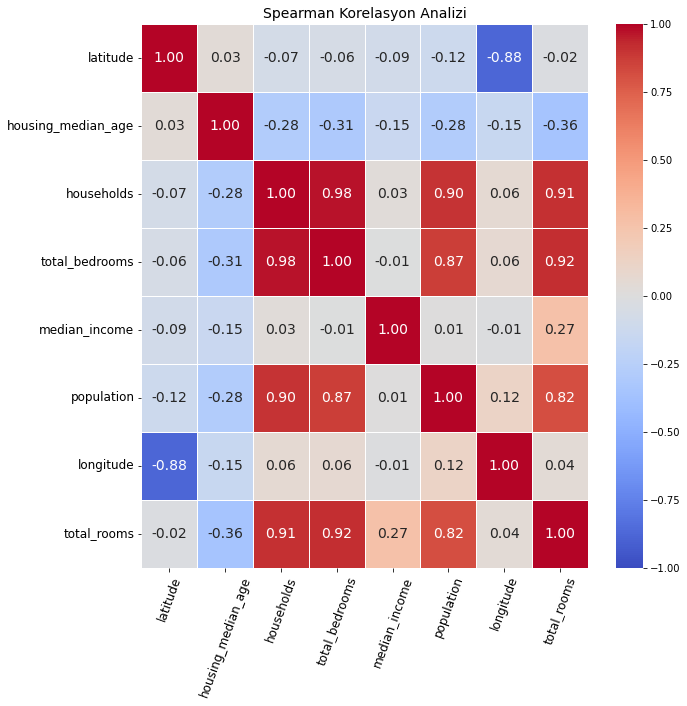

In [22]:
fig, axes = plt.subplots(figsize=(10,10))
sns.heatmap(korelasyon_tablosu,
            annot= True,
            linewidths=0.5,
            fmt = ".2f",
            vmax = 1,
            vmin = -1,
            ax=axes,
            annot_kws = {'size': 14},
            cmap ="coolwarm")
plt.xticks(rotation=70, size = 12)
plt.yticks(rotation=0, size = 12)
plt.title(f'{korelasyon_metot.title()} Korelasyon Analizi',size = 14)
plt.show()

[Yukarı Çık](#baslik)

### Eksik Değer Analizi <a name="eda"></a>

#### Eksik Değer Tablosu <a name="edt"></a>

In [23]:
eksik_degere_sahip_degiskenler = [col for col in df.columns if df[col].isnull().sum() > 0]
eksik_deger_sayisi = df[eksik_degere_sahip_degiskenler].isnull().sum().sort_values(ascending=False)
eksik_deger_orani = (df[eksik_degere_sahip_degiskenler].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
pd.concat([eksik_deger_sayisi, eksik_deger_orani], axis=1, keys=['eksik_deger_sayisi', 'eksik_deger_orani'])

,eksik_deger_sayisi,eksik_deger_orani
total_bedrooms,207,1.00291


[Yukarı Çık](#baslik)

#### Eksik Değerin Görselleştirilmesi <a name="edg"></a>

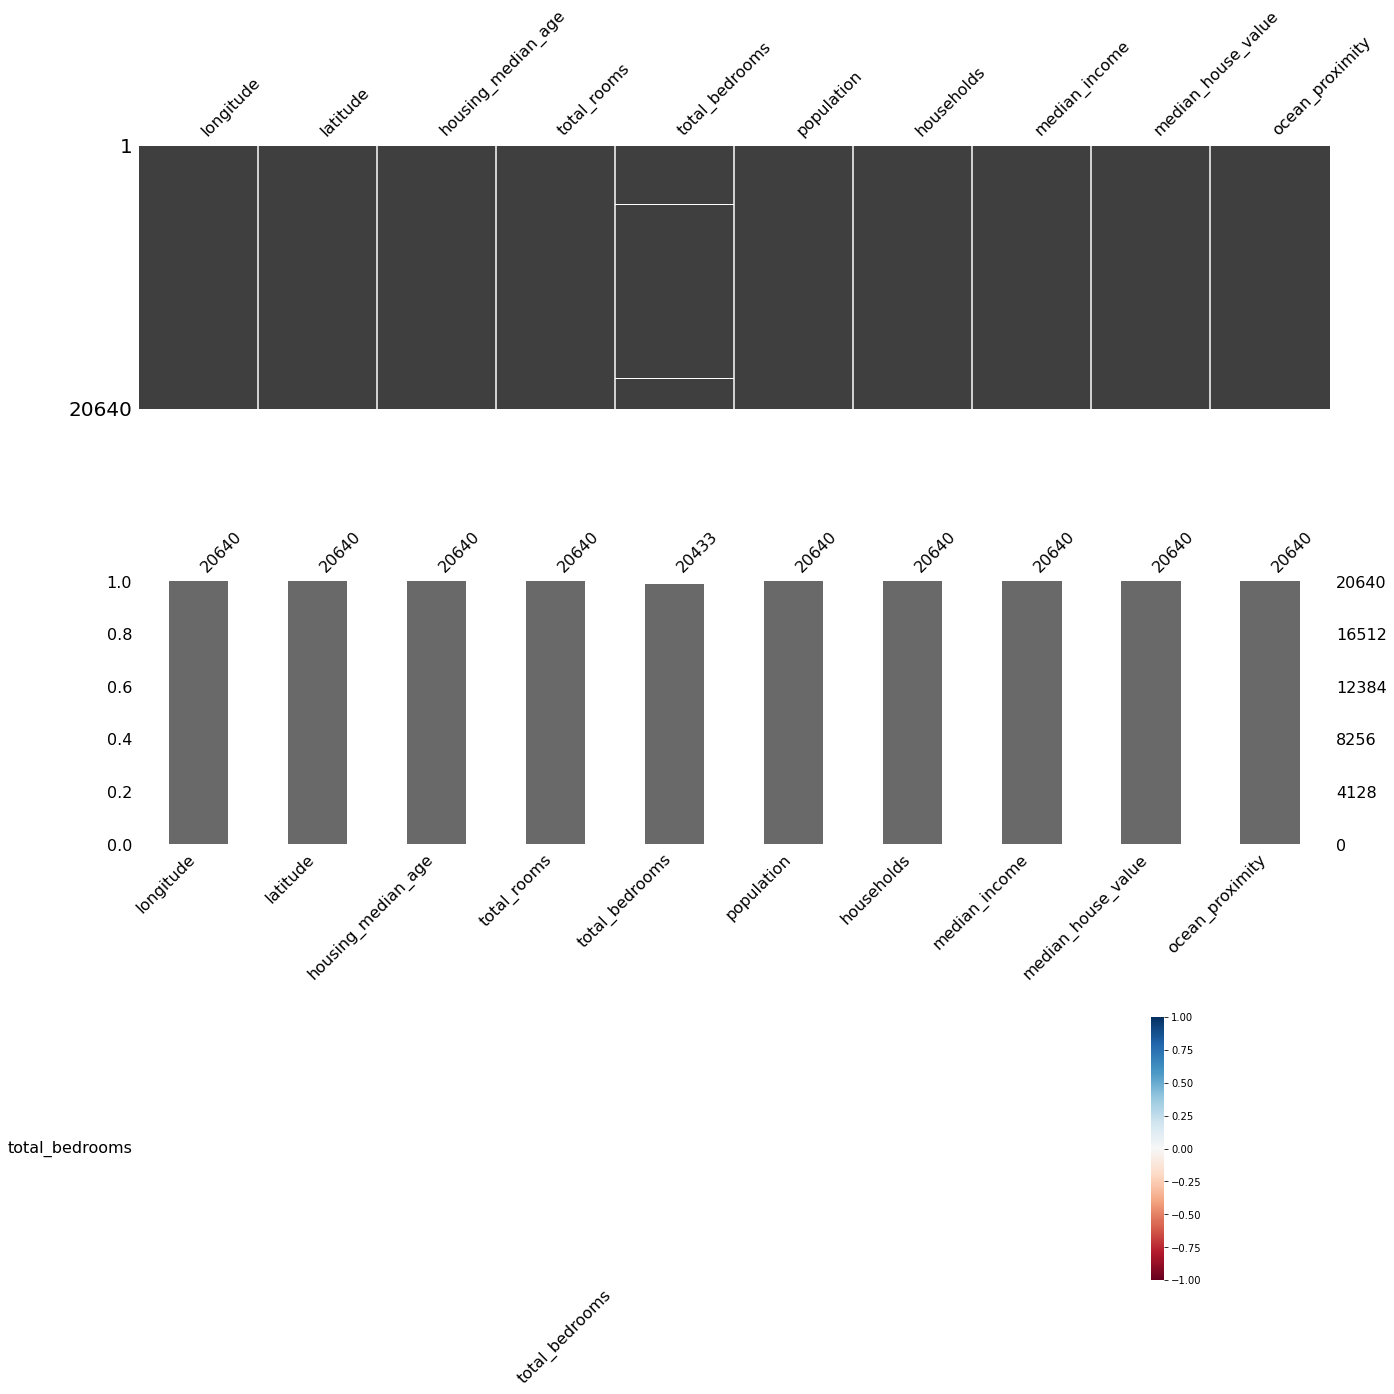

In [24]:
fig, axes = plt.subplots(3, figsize=(20,20))
msno.matrix(df, ax=axes[0], sparkline=False)
msno.bar(df, ax=axes[1])
msno.heatmap(df, ax=axes[2])
fig.tight_layout(pad=3.0)
plt.show()

[Yukarı Çık](#baslik)

#### Eksikliğin Hedef Değişken ile İlişkisi <a name="ehdi"></a>

In [25]:
temp_df = df.copy()

for degisken in eksik_degere_sahip_degiskenler:
    temp_df[degisken + '_EKSIK_MI'] = np.where(temp_df[degisken].isnull(), 1, 0)

eksik_sorgu_degiskenler = [degisken for degisken in temp_df.columns if '_EKSIK_MI' in degisken]

for degisken in eksik_sorgu_degiskenler:
    print(pd.DataFrame({'hedef_degisken_ortalama': temp_df.groupby(degisken)[hedef_degisken].mean(),
                        'hedef_degisken_medyan': temp_df.groupby(degisken)[hedef_degisken].median(),
                        'n': temp_df.groupby(degisken)[hedef_degisken].count()}))

                         hedef_degisken_ortalama  hedef_degisken_medyan      n
total_bedrooms_EKSIK_MI                                                       
0                                   206864.41316           179700.00000  20433
1                                   206007.28019           175000.00000    207


[Yukarı Çık](#baslik)

## Modele Hazırlık <a name="model-giris"></a>

### Tüm Değişkenlerin Sayısallaştırılması <a name="sayisallastirma"></a>

In [26]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23000,37.88000,41.00000,880.00000,129.00000,322.00000,126.00000,8.32520,452600.00000,0,0,1,0
1,-122.22000,37.86000,21.00000,7099.00000,1106.00000,2401.00000,1138.00000,8.30140,358500.00000,0,0,1,0
2,-122.24000,37.85000,52.00000,1467.00000,190.00000,496.00000,177.00000,7.25740,352100.00000,0,0,1,0
3,-122.25000,37.85000,52.00000,1274.00000,235.00000,558.00000,219.00000,5.64310,341300.00000,0,0,1,0
4,-122.25000,37.85000,52.00000,1627.00000,280.00000,565.00000,259.00000,3.84620,342200.00000,0,0,1,0


[Yukarı Çık](#baslik)

### Eksik Değerlerin Silinmesi <a name="eksik-deger-silme"></a>

In [27]:
df.dropna(inplace=True)

[Yukarı Çık](#baslik)

### Bağımlı Değişkenin ve Bağımsız Değişkenlerin Belirlenmesi <a name="degiskenleri-belirleme"></a>

In [28]:
# Bağımsız değişkenler
X = df[[col for col in df.columns.to_list() if col != hedef_degisken]].values

In [29]:
# Boyut bilgisi
X.shape

(20433, 12)

In [30]:
# Kontrol
X[:3]

array([[-1.2223e+02,  3.7880e+01,  4.1000e+01,  8.8000e+02,  1.2900e+02,
         3.2200e+02,  1.2600e+02,  8.3252e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       [-1.2222e+02,  3.7860e+01,  2.1000e+01,  7.0990e+03,  1.1060e+03,
         2.4010e+03,  1.1380e+03,  8.3014e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       [-1.2224e+02,  3.7850e+01,  5.2000e+01,  1.4670e+03,  1.9000e+02,
         4.9600e+02,  1.7700e+02,  7.2574e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00]])

In [31]:
# Bağımlı değişken
y = df[hedef_degisken].values

In [32]:
# Boyut bilgisi
y.shape

(20433,)

In [33]:
# Kontrol
y[:3]

array([452600., 358500., 352100.])

[Yukarı Çık](#baslik)

### Eğitim ve Test Setinin Ayrılması <a name="egitim-test"></a>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state = 42)

In [35]:
# Kontrol
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15324, 12)
(15324,)
(5109, 12)
(5109,)


[Yukarı Çık](#baslik)

## MLflow ile Modelleme <a name="mlflow-giris"></a>

### Modellerin Tanımlanması <a name="model-secim"></a>

In [36]:
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [37]:
model_dict = {"elasticnet": {"model": ElasticNet(random_state=42),
                             "params": ['alpha', 'l1_ratio']},
              "decisiontree": {"model": DecisionTreeRegressor(random_state=42),
                               "params": ['max_depth', 'min_samples_split']},
              "knn": {"model": KNeighborsRegressor(),
                      "params": ['algorithm', 'weights']}}

[Yukarı Çık](#baslik)

### Modellerin MLflow'a Gönderilmesi <a name="mlflow-logging"></a>

In [38]:
for model_type in model_dict:
    mlflow.set_experiment("HousingPricePrediction")
    experiment = mlflow.get_experiment_by_name("HousingPricePrediction")
    with mlflow.start_run(run_name=f'noreg-{model_type}-sklearn', experiment_id=experiment.experiment_id):
        # Modelin eğitilmesi
        model = model_dict[model_type]["model"]
        model.fit(X_train, y_train)

        # Model başarı metriklerinin hesaplanması
        predicted_qualities = model.predict(X_test)
        (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
        
        # Model parametreleri
        model_param_1 = model_dict[model_type]["params"][0]
        model_param_2 = model_dict[model_type]["params"][1]
        
        # MLflow loglama işlemi
        mlflow.log_param(model_param_1, model.get_params()[model_param_1])
        mlflow.log_param(model_param_2, model.get_params()[model_param_2])
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        # (Model Registry seçeneği için) dosya tipi kontrolü
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, "model") # Eğer model registry kullanmamız gerekseydi registered_model_name parametresini kullanırdık
        else:
            mlflow.sklearn.log_model(model, "model")
    print(f"{model_type} successful logged.")

elasticnet successful logged.
decisiontree successful logged.
knn successful logged.


[Yukarı Çık](#baslik)